# Show image and its prediction
* Note: In versions of TensorFlow before 1.2, we recommended using multi-threaded, queue-based input pipelines for performance. Beginning with TensorFlow 1.2, however, we recommend using the tf.contrib.data module instead. (See [Datasets](https://www.tensorflow.org/programmers_guide/datasets) for details. The tf.contrib.data module offers an easier-to-use interface for constructing efficient input pipelines. Furthermore, we've stopped developing the old multi-threaded, queue-based input pipelines. We've retained the documentation in this file to help developers who are still maintaining older code.

In [55]:
import tensorflow as tf
from tensorflow.contrib import slim
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

In [56]:
FILE_DIR = '/home/wangx/project/show_single_pred/images'
IMAGE_SIZE = vgg.vgg_16.default_image_size
NUM_EPOCHS = 10
CHECKPOINTS_DIR = '/home/wangx/project/show_single_pred/checkpoints'

In [57]:
def get_files(file_dir):
    filenames = []
    labels = []

    for line in open('test.txt'):
        line = line.strip('\n') + '.jpg'
        labels.append(line.split('/')[0])
        filenames.append(os.path.join(file_dir, line))

    print('There are totally {} files.'.format(len(labels)))
    print('For example: ',filenames[0])
    return filenames, labels

In [58]:
filenames, labels = get_files(FILE_DIR)

There are totally 17858 files.
For example:  /home/wangx/project/show_single_pred/images/0/n02854926/n02854926_1007_0.jpg


In [82]:
names = imagenet.create_readable_names_for_imagenet_labels()

There are totally 17858 files.
For example:  /home/wangx/project/show_single_pred/images/0/n02854926/n02854926_1007_0.jpg
INFO:tensorflow:Restoring parameters from /home/wangx/project/show_single_pred/checkpoints/vgg_16.ckpt
Probability 0.61 => [lab coat, laboratory coat]
Probability 0.11 => [sweatshirt]
Probability 0.06 => [trench coat]
Probability 0.05 => [suit, suit of clothes]
Probability 0.03 => [Windsor tie]


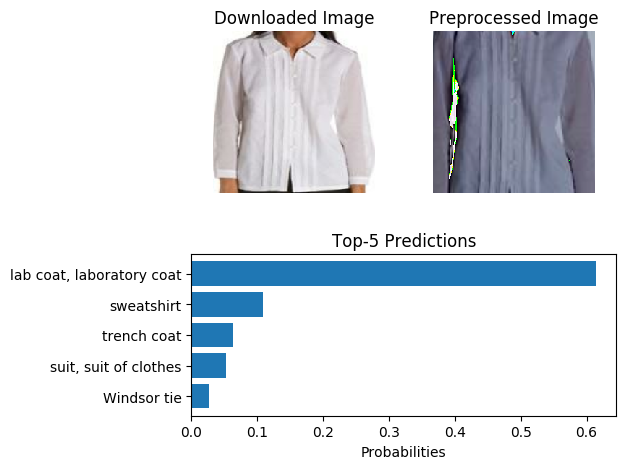

Probability 0.13 => [lab coat, laboratory coat]
Probability 0.05 => [plastic bag]
Probability 0.04 => [pajama, pyjama, pj's, jammies]
Probability 0.04 => [hoopskirt, crinoline]
Probability 0.03 => [overskirt]


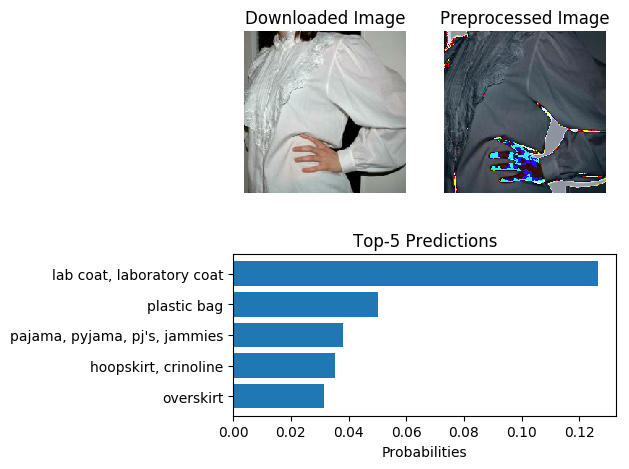

Probability 0.79 => [trench coat]
Probability 0.06 => [Windsor tie]
Probability 0.05 => [suit, suit of clothes]
Probability 0.02 => [lab coat, laboratory coat]
Probability 0.01 => [cloak]


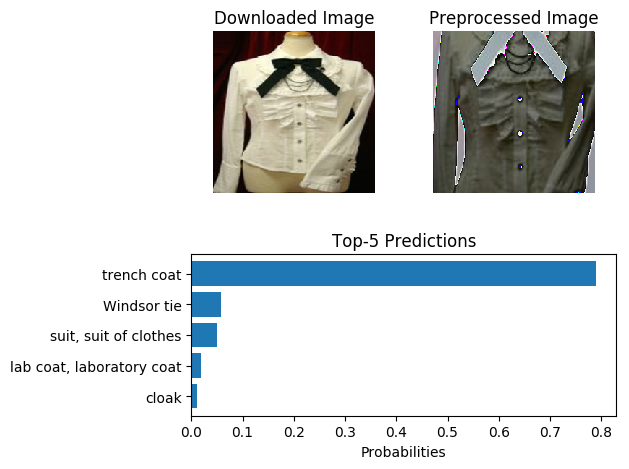

In [120]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize_images(image_decoded,
                                           [IMAGE_SIZE,IMAGE_SIZE])
    processed_img = vgg_preprocessing.preprocess_image(image_decoded,
                                                        IMAGE_SIZE,
                                                        IMAGE_SIZE,
                                                        is_training=False)
    raw_img = image_resized
    return raw_img, processed_img, label

filenames, labels = get_files(FILE_DIR)


with tf.Graph().as_default():
    dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    #dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(1)
    dataset = dataset.repeat(NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()

    next_raw_img, next_processed_img, next_label = iterator.get_next()
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logit, _ = vgg.vgg_16(next_processed_img, num_classes=1000, is_training=False)

    probabilities = tf.nn.softmax(logit)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(CHECKPOINTS_DIR, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
        
    with tf.train.MonitoredTrainingSession() as sess:
        init_fn(sess)
        i = 0
        while not sess.should_stop() and i<3:
            np_raw_img, np_processed_img, np_probabilities = sess.run([next_raw_img,
                                                                       next_processed_img,
                                                                       probabilities])
            np_probabilities = np_probabilities[0, 0:]
            sorted_idx = [i[0] for i in sorted(
                enumerate(-np_probabilities), key=lambda x:x[1])]
            
            pred_class = []
            pred_prob = []
            for t in range(5):
                index = sorted_idx[t]
                print("Probability %0.2f => [%s]" % (np_probabilities[index], names[index+1]))
                pred_class.append(names[index+1])
                pred_prob.append(np_probabilities[index])
                
            plt.rcdefaults()
            fig = plt.figure()
            ax1 = plt.subplot2grid((2,2),(0,0))
            ax2 = plt.subplot2grid((2,2),(0,1))
            ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
            ax1.imshow(np_raw_img[0].astype(np.uint8))
            ax1.set_title('Downloaded Image')
            ax1.axis('off')
            ax2.imshow(np_processed_img[0]/(
                np_processed_img[0].max() - np_processed_img[0].min()))
            ax2.set_title('Preprocessed Image')
            ax2.axis('off')
            
            y_pos = np.arange(len(pred_class))
            ax3.barh(y_pos, pred_prob)
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(pred_class)
            ax3.invert_yaxis()
            ax3.set_xlabel('Probabilities')
            ax3.set_title('Top-5 Predictions')
            plt.tight_layout()
            plt.show()
            
            i += 1
